In [3]:
%matplotlib inline

In [15]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import mannwhitneyu, ttest_ind, wilcoxon, ttest_rel
import os
import nibabel as nib
from nilearn.surface import load_surf_data
from linescanning import prf

opj = os.path.join

## <h1> ROI Size Analysis </h1>
This notebook is used to plot the sizes of V1, V2, V3 for all subjects and include the $R^2$.

In [18]:
root_folder = '/data1/projects/Meman1/projects/pilot/derivatives/freesurfer'
subs = ['sub-001','sub-002','sub-003','sub-004','sub-005','sub-007','sub-008','sub-010','sub-012','sub-013','sub-015','sub-016']
rois = ['V1','V2','V3']
paramsrois = {sub: {roi: None for roi in rois} for sub in subs}

In [6]:
size_df = pd.DataFrame(columns=['sub', 'V1', 'V2', 'V3'])

for sub in subs:              #loop over all subjects
    finalrois= opj(root_folder, sub, 'customlabel', 'roidrawing', 'final')

    #Load V1 vertices from left hemisphere, together with the number of vertices in the left hemisphere so indexing for right hemisphere works appropriately; the .label files start from 0 and work per hemisphere, whereas Inkscape merges the two hemispheres together.
    V1_lh = nib.freesurfer.read_label(opj(finalrois, 'lh.V1.label'))
    V2_lh = nib.freesurfer.read_label(opj(finalrois, 'lh.V2.label'))
    V3_lh = nib.freesurfer.read_label(opj(finalrois, 'lh.V3.label'))

    all_lh = nib.freesurfer.read_geometry(opj(root_folder, sub, 'surf', 'lh.inflated'))

    #Load V1 vertices from right hemisphere. 
    V1_rh = nib.freesurfer.read_label(opj(finalrois, 'rh.V1.label'))
    V2_rh = nib.freesurfer.read_label(opj(finalrois, 'rh.V2.label'))
    V3_rh = nib.freesurfer.read_label(opj(finalrois, 'rh.V3.label'))

    all_rh = nib.freesurfer.read_geometry(opj(root_folder, sub, 'surf', 'rh.inflated'))

    # Get the right indices for the right hemisphere by adding the number of vertices in left hemisphere to the ROI indices for the right hemisphere.
    V1_rh = V1_rh + len(all_lh[0])
    V2_rh = V2_rh + len(all_lh[0])
    V3_rh = V3_rh + len(all_lh[0])

    #Concatenate the 2 and sort them such that they are in the right order
    V1_vertices = np.sort(np.concatenate([V1_lh, V1_rh]))
    V2_vertices = np.sort(np.concatenate([V2_lh, V2_rh]))
    V3_vertices = np.sort(np.concatenate([V3_lh, V3_rh]))

    size_df.loc[len(size_df.index)] = [sub, len(V1_vertices), len(V2_vertices), len(V3_vertices)]


In [7]:
size_df

,sub,V1,V2,V3
0,sub-001,1363,1394,1617
1,sub-002,3163,2656,2157
2,sub-003,3685,3553,2632
3,sub-004,2681,2419,2102
4,sub-005,2347,2095,1623
5,sub-007,2836,2801,2138
6,sub-008,2596,2220,1684
7,sub-010,1241,1373,2076
8,sub-012,2798,2557,2464
9,sub-013,3421,2942,2076


In [8]:
print(f"Mean V1 size is {np.mean(size_df['V1'].values)}, standard deviation is {np.std(size_df['V1'].values)}")
print(f"Mean V2 size is {np.mean(size_df['V2'].values)}, standard deviation is {np.std(size_df['V2'].values)}")
print(f"Mean V3 size is {np.mean(size_df['V3'].values)}, standard deviation is {np.std(size_df['V3'].values)}")

Mean V1 size is 2543.0833333333335, standard deviation is 710.2673743426172
Mean V2 size is 2383.0, standard deviation is 587.5505651998529
Mean V3 size is 1988.75, standard deviation is 342.30471926827613


<h1>R2 calculations</h1>

In [12]:
deriv='/data1/projects/Meman1/projects/pilot/derivatives'

In [13]:
class get_basic_params:
    # Class to do some filtering on a pRFmodelFitting object on Gaussian model. You mainly specify the eccentricities that you want to look at, your minimum r2, and potentially a ROI

    def __init__(self,
                 pRFmodelFitting=None,
                 data=None,
                 design=None,
                 model=None,
                 stage=None,
                 params=None,
                 roi=None,
                 eccmask=[minecc, maxecc],
                 r2mask=minr2):
        
        self.pRFmodelFitting=pRFmodelFitting
        if isinstance(self.pRFmodelFitting, prf.pRFmodelFitting):
            # if pRFmodelFitting object, get the necessary settings from here
            self.data=self.pRFmodelFitting.data
            self.model=self.pRFmodelFitting.model
            self.stage=self.pRFmodelFitting.stage
            self.params=prf.Parameters(params=getattr(self.pRFmodelFitting, f"{self.model}_{self.stage}"), model=self.model).to_df()
            self.design=self.pRFmodelFitting.design_matrix

        else:
            # else, take from manual input
            self.data=data
            self.model=model
            self.stage=stage
            self.params=params
            self.design=design
            
        # some additional settings
        self.eccmask=eccmask
        self.r2mask=r2mask
        self.roi=roi

        # select vertices based on roi...
        if self.roi is not None:
            try:
                self.params=self.params.loc[self.roi]
                print("ROI has", len(self.roi), "values")
            except:
                print("Not a valid ROI, give an array with vertex numbers for the ROI")
                print(len(self.roi))
                
        # drop vertices based on eccentricity and r2 boundaries
        self.params.loc[self.params['ecc'].values < self.eccmask[0]] = np.nan
        self.params.loc[self.params['ecc'].values > self.eccmask[1]] = np.nan
        self.params.loc[self.params['r2'].values < self.r2mask] = np.nan

        print("Excluding", self.params.isna().any(axis=1).sum(), 'vertices based on mask...')
        
        self.params=self.params.dropna()
        self.params=self.params[['x','y','r2']]


In [20]:
for sub in subs:
    
    # load params
    paramsfile = opj(deriv, 'prf', sub, f'{sub}_ses-avg_task-2R_model-gauss_stage-iter_desc-prf_params.pkl')
    data = np.load(opj(deriv, 'prf', sub, f'{sub}_ses-avg_task-2R_hemi-LR_desc-avg_bold.npy'))
    design = prf.read_par_file(opj(deriv, 'prf', sub, 'design_task-2R.mat'))
    paramsfile = opj(deriv, 'prf', sub, f'{sub}_ses-avg_task-2R_model-gauss_stage-iter_desc-prf_params.pkl')

    
    gauss= prf.pRFmodelFitting(
    data.T,
    design_matrix=design,
    TR=1.5,                     # default
    model='gauss',              # default, can be 'gauss', 'css', 'dog', 'norm'
    stage="iter",               # default
    verbose=True,               # keep track of what we're doing,
    fix_bold_baseline=True      # fix the BOLD baseline at 0
    )

    # load params, also load prf_obj
    gauss.load_params(paramsfile, model='gauss', stage="iter")

    # now, load ROIs:
    #Load V1 vertices from left hemisphere, together with the number of vertices in the left hemisphere so indexing for right hemisphere works appropriately; the .label files start from 0 and work per hemisphere, whereas Inkscape merges the two hemispheres together.
    V1_lh = nib.freesurfer.read_label(f"{deriv}/freesurfer/{sub}/customlabel/roidrawing/lh.V1.label")
    V2_lh = nib.freesurfer.read_label(f"{deriv}/freesurfer/{sub}/customlabel/roidrawing/lh.V2.label")
    V3_lh = nib.freesurfer.read_label(f"{deriv}/freesurfer/{sub}/customlabel/roidrawing/lh.V3.label")

    all_lh = nib.freesurfer.read_geometry(f"{deriv}/freesurfer/{sub}/surf/lh.inflated")

    #Load V1 vertices from right hemisphere. 
    V1_rh = nib.freesurfer.read_label(f"{deriv}/freesurfer/{sub}/customlabel/roidrawing/rh.V1.label")
    V2_rh = nib.freesurfer.read_label(f"{deriv}/freesurfer/{sub}/customlabel/roidrawing/rh.V2.label")
    V3_rh = nib.freesurfer.read_label(f"{deriv}/freesurfer/{sub}/customlabel/roidrawing/rh.V3.label")

    all_rh = nib.freesurfer.read_geometry(f"{deriv}/freesurfer/{sub}/surf/rh.inflated")

    # Get the right indices for the right hemisphere by adding the number of vertices in left hemisphere to the ROI indices for the right hemisphere.
    V1_rh = V1_rh + len(all_lh[0])
    V2_rh = V2_rh + len(all_lh[0])
    V3_rh = V3_rh + len(all_lh[0])

    #Concatenate the 2 and sort them such that they are in the right order
    V1_vertices = np.sort(np.concatenate([V1_lh, V1_rh]))
    V2_vertices = np.sort(np.concatenate([V2_lh, V2_rh]))
    V3_vertices = np.sort(np.concatenate([V3_lh, V3_rh]))

    # now, filter
    paramsrois[sub]['V1']= get_basic_params(gauss, r2mask=0.3, eccmask=[0.5, 4.5], roi=V1_vertices)
    paramsrois[sub]['V2']= get_basic_params(gauss, r2mask=0.3, eccmask=[0.5, 4.5], roi=V2_vertices)
    paramsrois[sub]['V3']= get_basic_params(gauss, r2mask=0.3, eccmask=[0.5, 4.5], roi=V3_vertices)

Design has 5 more volumes than timecourses, trimming from beginning of design to (100, 100, 220)
Reading settings from '/data1/projects/Meman1/projects/pilot/code/prf_analysis.yml'

---------------------------------------------------------------------------------------------------
Check these important settings!
 Screen distance: 196cm
 Screen size: 39.3cm
 TR: 1.5s
---------------------------------------------------------------------------------------------------

Fixing baseline at [0, 0]
Instantiate HRF with: [1, 1, 0] (fit=True)
Using constraint(s): ['tc', 'tc']
Reading settings from '/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-001/sub-001_ses-avg_task-2R_model-gauss_stage-iter_desc-prf_params.pkl' (safest option; overwrites other settings)

---------------------------------------------------------------------------------------------------
Check these important updated settings!
 Screen distance: 196cm
 Screen size: 39.3cm
 TR: 1.5s
-----------------------------------

In [31]:
# Initialize an empty list to store individual dataframes
dfs = []

# Iterate through each subject and its corresponding dataframe
for subject, dic in paramsrois.items():
    # Extract the dataframe
    for roi, obj in dic.items():
        dfroi = obj.params
        # Add a 'subject' column with the subject's name
        dfroi['subject'] = subject
        dfroi['ROI'] = roi
        # Append the modified dataframe to the list
        dfs.append(dfroi[['subject', 'ROI', 'x', 'y','r2']])

# Concatenate all dataframes in the list along rows
merged_df_roi = pd.concat(dfs, ignore_index=True)

In [ ]:
# Transform the DataFrame using melt
sizes_melted = pd.melt(size_df, id_vars=['sub'], value_vars=['V1', 'V2', 'V3'], var_name='ROI', value_name='size')

Now, create plot

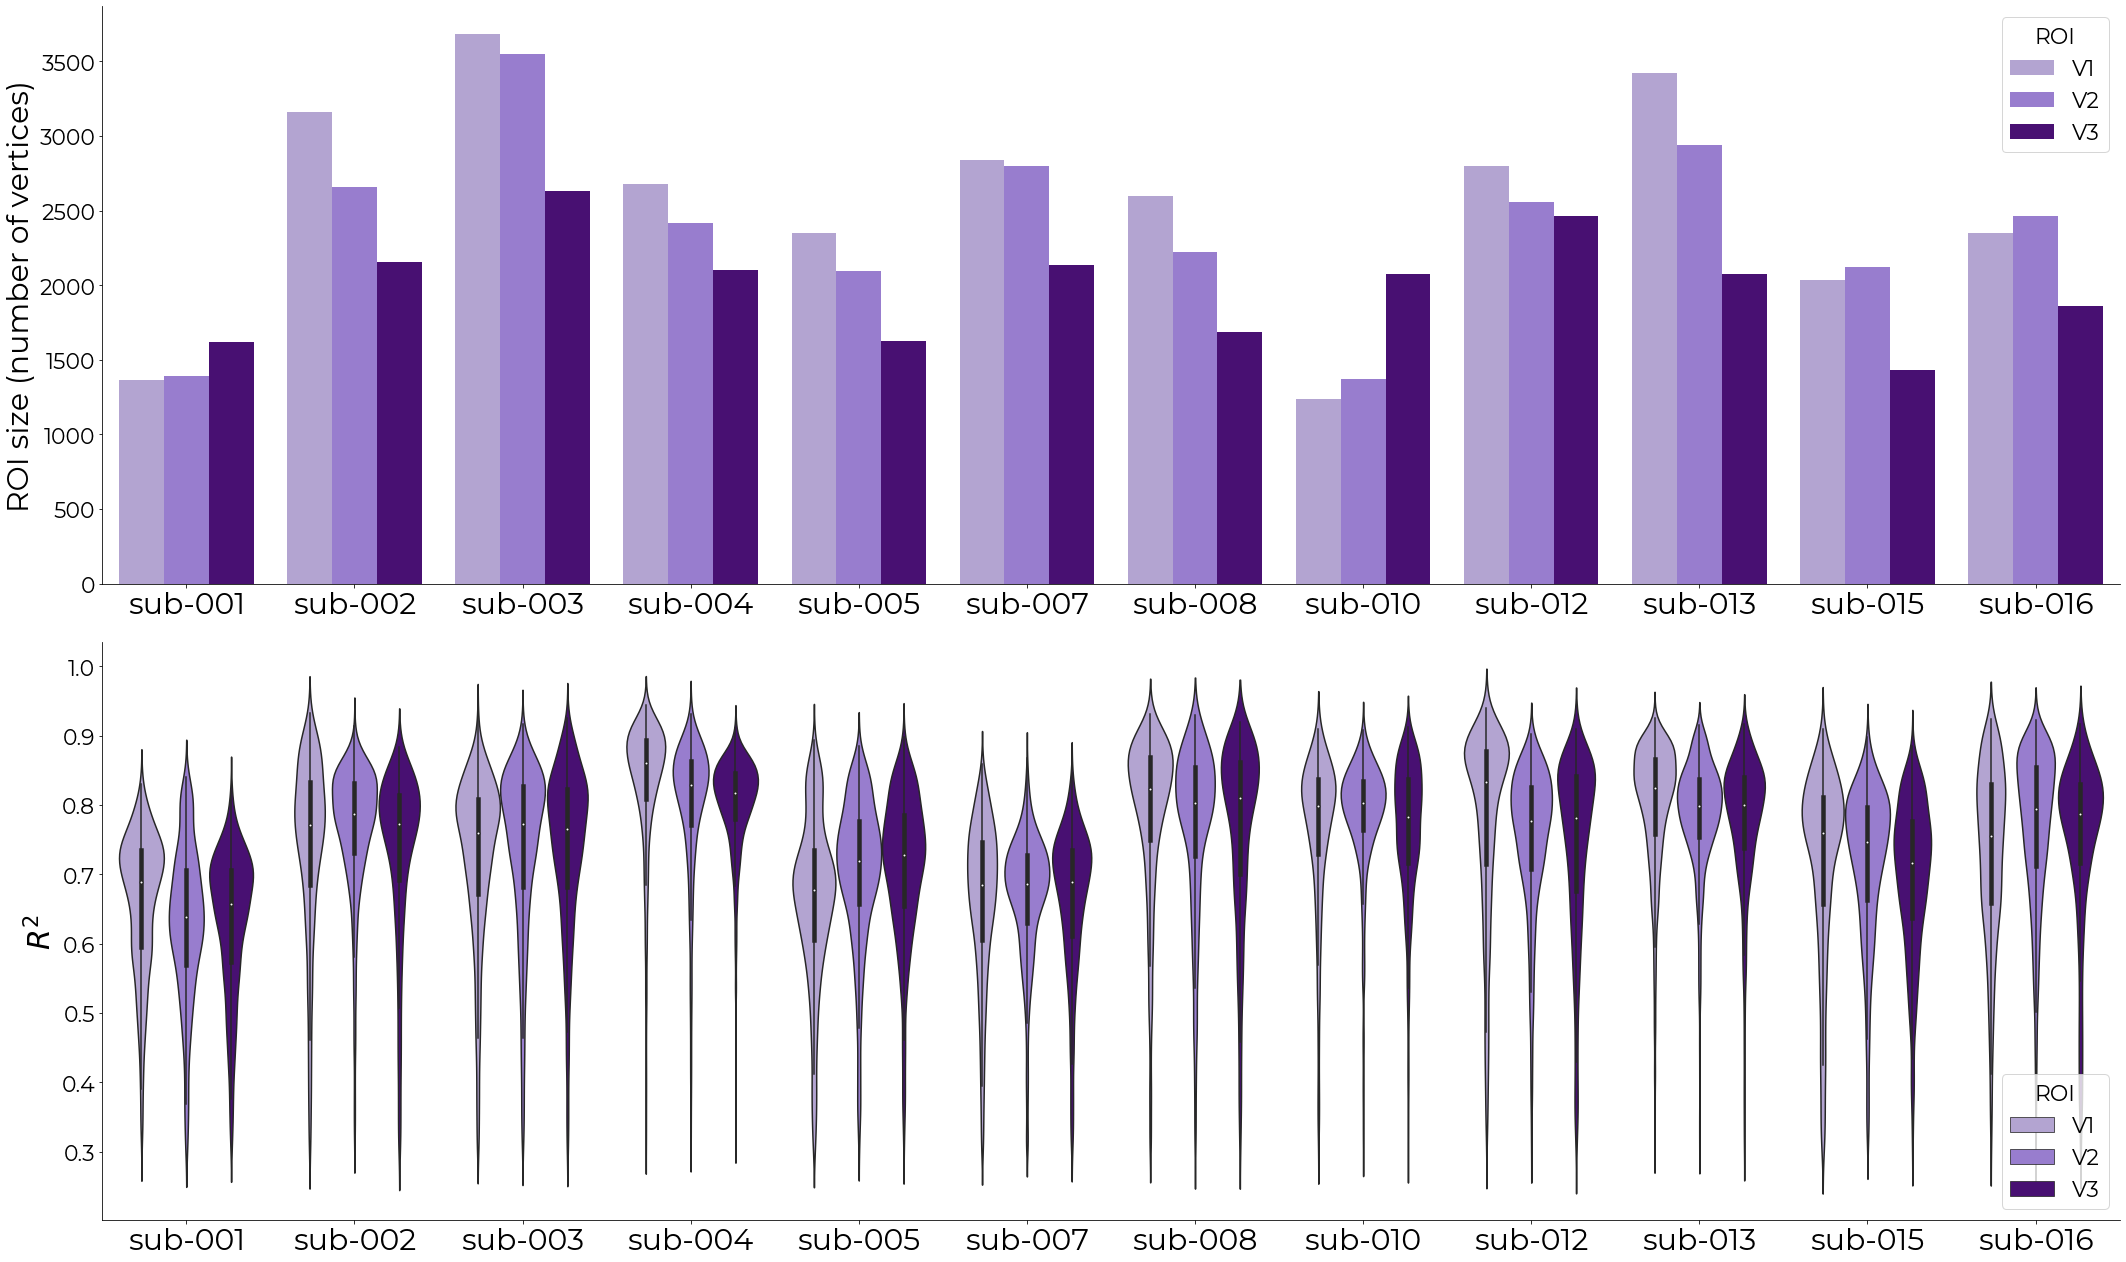

In [35]:
# Create the custom palette
# Define the shades of purple
light_purple = "#B19CD9"
medium_purple = "#9370DB"
dark_purple = "#4B0082"
custom_palette = [light_purple, medium_purple, dark_purple]

plt.rcParams.update({'font.family':'Montserrat'})

plt.rcParams.update({'font.size': 22})
plt.rcParams.update({'xtick.labelsize': 30})

# Plot
fig, ax = plt.subplots(2,1,figsize=(30, 18))

sns.barplot(data=sizes_melted, x='sub', y='size', hue='ROI', palette=custom_palette, ax=ax[0])
ax[0].set_ylabel('ROI size (number of vertices)', fontsize=30)
ax[0].set_xlabel('')

sns.violinplot(x="subject", y='r2', hue="ROI", data=merged_df_roi, palette=custom_palette, ax=ax[1])
ax[1].set_ylabel('$R^2$', fontsize=30)
ax[1].set_xlabel('')

save_path = "/data1/projects/Meman1/projects/pilot/code/floris/figures/gaussianfits.png"
plt.tight_layout()

sns.despine()
plt.savefig(save_path)
plt.show()